#### **Pytorch Workflow Fundamentals**

![pytorch-workflow.png](./images/pytorch-workflow.png)

Let's start by putting what we're covering into a dictionary to reference later.

In [1]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

We're going to get torch, torch.nn (nn stands for neural network and this package contains the building blocks for creating neural networks in PyTorch) and matplotlib.

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu117'

1. Data (preparing and loading)

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02

# We pass .unsqueeze(dim=1) to add one more dimension to our tensor, dim=1 means we add it column-wise
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
from sklearn.model_selection import train_test_split

# For now we just divide our data into train and test sets

X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Wonderful, we've got 40 samples for training (X_train & y_train) and 10 samples for testing (X_test & y_test).

The model we create is going to try and learn the relationship between X_train & y_train and then we will evaluate what it learns on X_test and y_test.

But right now our data is just numbers on a page.

Let's create a function to visualize it.

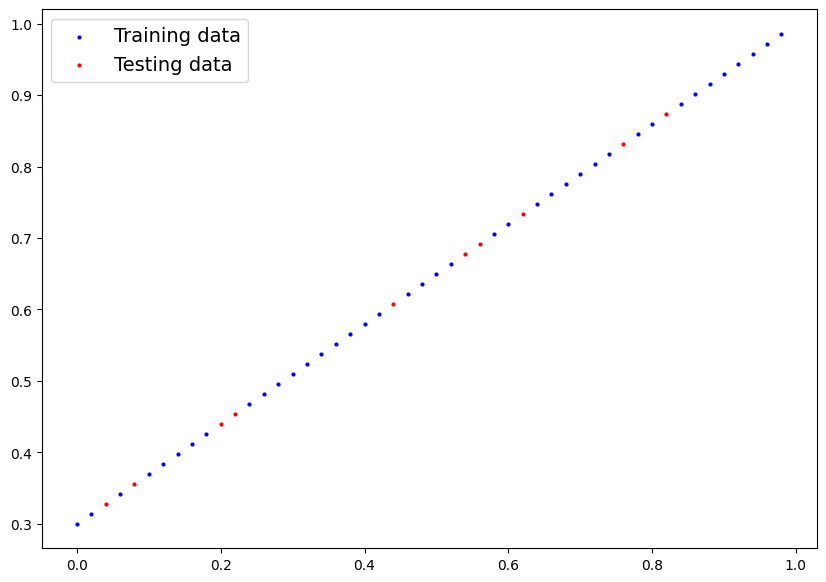

In [5]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="r", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="green", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

plot_predictions();

2. Build model

Now we've got some data, let's build a model to use the blue dots to predict the green dots.

We're going to jump right in.

We'll write the code first and then explain everything.

Let's replicate a standard linear regression model using pure PyTorch.

In [6]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

![pytorch-model-building.png](./images/pytorch-model-building.png)

Checking the contents of a PyTorch model

Now we've got these out of the way, let's create a model instance with the class we've made and check its parameters using `.parameters()`.

In [7]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can also get the state (what the model contains) of the model using `.state_dict()`.

In [8]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

Notice how the values for weights and bias from `model_0.state_dict()` come out as random float tensors?

This is because we initialized them above using `torch.randn()`.

Essentially we want to start from random parameters and get the model to update them towards parameters that fit our data best (the hardcoded weight and bias values we set when creating our straight line data).

>Exercise: Try changing the `torch.manual_seed()` value two cells above, see what happens to the weights and bias values.

Because our model starts with random values, right now it'll have poor predictive power.

Making predictions using `torch.inference_mode()`

To check this we can pass it the test data `X_test` to see how closely it predicts `y_test`.

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined.

Let's make some predictions.

In [9]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

You probably noticed we used `torch.inference_mode()` as a context manager (that's what the with `torch.inference_mode():` is) to make the predictions.

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bunch of things (like **gradient tracking**, which is necessary for training but not for inference) to make **forward-passes** (data going through the `forward()` method) faster.

We've made some predictions, let's see what they look like.

In [10]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3174],
        [0.2029],
        [0.1961],
        [0.4049],
        [0.1423],
        [0.3106],
        [0.3847],
        [0.3376],
        [0.2770],
        [0.1557]])


Notice how there's one prediction value per testing sample.

This is because of the kind of data we're using. For our straight line, one `X` value maps to one `y` value.

However, machine learning models are very flexible. You could have 100 `X` values mapping to one, two, three or 10 `y` values. It all depends on what you're working on.

Our predictions are still numbers on a page, let's visualize them with our `plot_predictions()` function we created above.

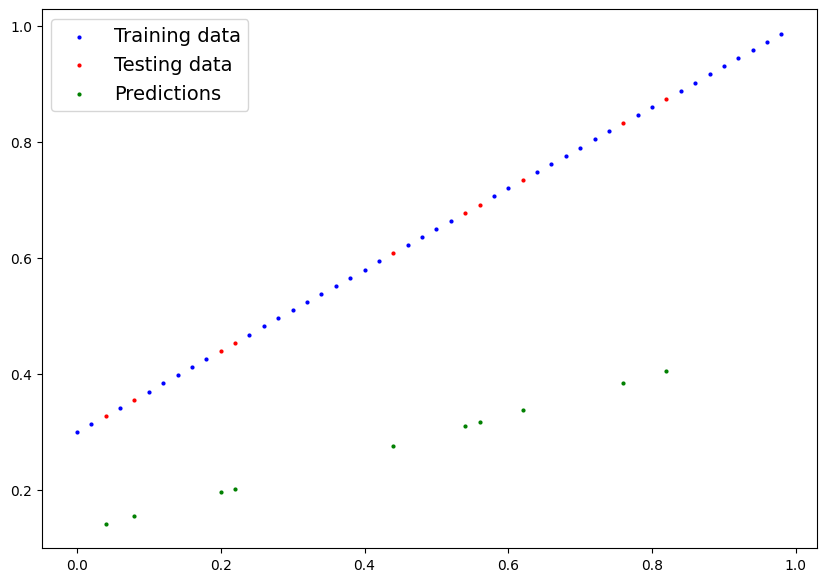

In [11]:
plot_predictions(predictions=y_preds)

In [12]:
y_test - y_preds

tensor([[0.3746],
        [0.2511],
        [0.2439],
        [0.4691],
        [0.1857],
        [0.3674],
        [0.4473],
        [0.3964],
        [0.3310],
        [0.2003]])


Woah! Those predictions look pretty bad...

This make sense though when you remember our model is just using random parameter values to make predictions.

It hasn't even looked at the blue dots to try to predict the red dots.

Time to change that.

3. Train model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (I also refer to parameters as **patterns**), the weights and bias values we set randomly using nn.Parameter() and torch.randn() to be something that better represents the data.

We could hard code this (since we know the default values weight=0.7 and bias=0.3) but where's the fun in that?

Much of the time you won't know what the ideal parameters are for a model.

Instead, it's much more fun to write code to see if the model can try and figure them out itself.

Creating a loss function and optimizer in PyTorch

For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a **loss function** as well as an **optimizer**.

Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another).

For our problem, since we're predicting a number, let's use MAE (which is under `torch.nn.L1Loss()`) in PyTorch as our loss function.

Mean absolute error (MAE, in PyTorch: torch.nn.L1Loss) measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.

And we'll use SGD, `torch.optim.SGD(params, lr)` where:

- `params` is the target model parameters you'd like to optimize (e.g. the weights and bias values we randomly set before).
- `lr` is the learning rate you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a hyperparameter (because it's set by a machine learning engineer). Common starting values for the learning rate are 0.01, 0.001, 0.0001, however, these can also be adjusted over time (this is called learning rate scheduling).

In [13]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

Creating an optimization loop in PyTorch

Woohoo! Now we've got a loss function and an optimizer, it's now time to create a training loop (and testing loop).

The training loop involves the model going through the training data and learning the relationships between the features and labels.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never see's the testing data during training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

![pytorch-training-loop](./images/pytorch-training-loop.png)

Note: The above is just one example of how the steps could be ordered or described. With experience you'll find making PyTorch training loops can be quite flexible.

And on the ordering of things, the above is a good default order but you may see slightly different orders. Some rules of thumb:

- Calculate the loss (loss = ...) before performing backpropagation on it (loss.backward()).
- Zero gradients (optimizer.zero_grad()) before stepping them (optimizer.step()).
- Step the optimizer (optimizer.step()) after performing backpropagation on the loss (loss.backward()).

Pytorch Testing Loop

![pytorch-testing-loop](./images/pytorch-testing-loop.png)

Notice the testing loop doesn't contain performing backpropagation `(loss.backward())` or stepping the optimizer `(optimizer.step())`, this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.


Let's put all of the above together and train our model for 100 epochs (forward passes through the data) and we'll evaluate it every 10 epochs.

In [14]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.3548435568809509 | MAE Test Loss: 0.3145235478878021 
Epoch: 10 | MAE Train Loss: 0.2292904555797577 | MAE Test Loss: 0.1928880661725998 
Epoch: 20 | MAE Train Loss: 0.1091642752289772 | MAE Test Loss: 0.08336130529642105 
Epoch: 30 | MAE Train Loss: 0.05845985561609268 | MAE Test Loss: 0.05181314796209335 
Epoch: 40 | MAE Train Loss: 0.047578632831573486 | MAE Test Loss: 0.04278183355927467 
Epoch: 50 | MAE Train Loss: 0.04211265593767166 | MAE Test Loss: 0.037698663771152496 
Epoch: 60 | MAE Train Loss: 0.036971401423215866 | MAE Test Loss: 0.032977424561977386 
Epoch: 70 | MAE Train Loss: 0.03183014318346977 | MAE Test Loss: 0.028256157413125038 
Epoch: 80 | MAE Train Loss: 0.02668888494372368 | MAE Test Loss: 0.02364099957048893 
Epoch: 90 | MAE Train Loss: 0.021547632291913033 | MAE Test Loss: 0.019117575138807297 



Oh would you look at that! Looks like our loss is going down with every epoch, let's plot it to find out.

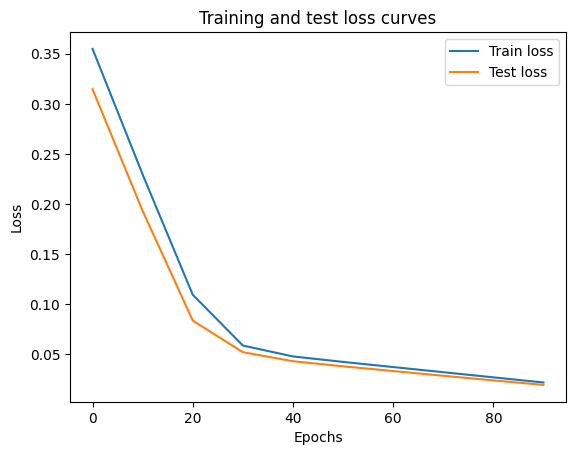

In [15]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Nice! The loss curves show the loss going down over time. Remember, loss is the measure of how wrong your model is, so the lower the better.

But why did the loss go down?

Well, thanks to our loss function and optimizer, the model's internal parameters (weights and bias) were updated to better reflect the underlying patterns in the data.

Let's inspect our model's `.state_dict()` to see see how close our model gets to the original values we set for weights and bias.

In [16]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6372])), ('bias', tensor([0.3363]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


Wow! How cool is that?

Our model got very close to calculate the exact original values for weight and bias (and it would probably get even closer if we trained it for longer).

>Exercise: Try changing the epochs value above to 200, what happens to the loss curves and the weights and bias parameter values of the model?

It'd likely never guess them perfectly (especially when using more complicated datasets) but that's okay, often you can do very cool things with a close approximation.

This is the whole idea of machine learning and deep learning, there are some ideal values that describe our data and rather than figuring them out by hand, we can train a model to figure them out programmatically.

4. Making predictions with a trained PyTorch model (inference)

Once you've trained a model, you'll likely want to make predictions with it.

We've already seen a glimpse of this in the training and testing code above, the steps to do it outside of the training/testing loop are similar.

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

- Set the model in evaluation mode (`model.eval()`).
- Make the predictions using the inference mode context manager (`with torch.inference_mode():` ...).
- All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).
The first two items make sure all helpful calculations and settings PyTorch uses behind the scenes during training but aren't necessary for inference are turned off (this results in faster computation). And the third ensures that you won't run into cross-device errors.

In [17]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.6932],
        [0.4765],
        [0.4638],
        [0.8588],
        [0.3618],
        [0.6804],
        [0.8206],
        [0.7314],
        [0.6167],
        [0.3873]])

Nice! We've made some predictions with our trained model, now how do they look?

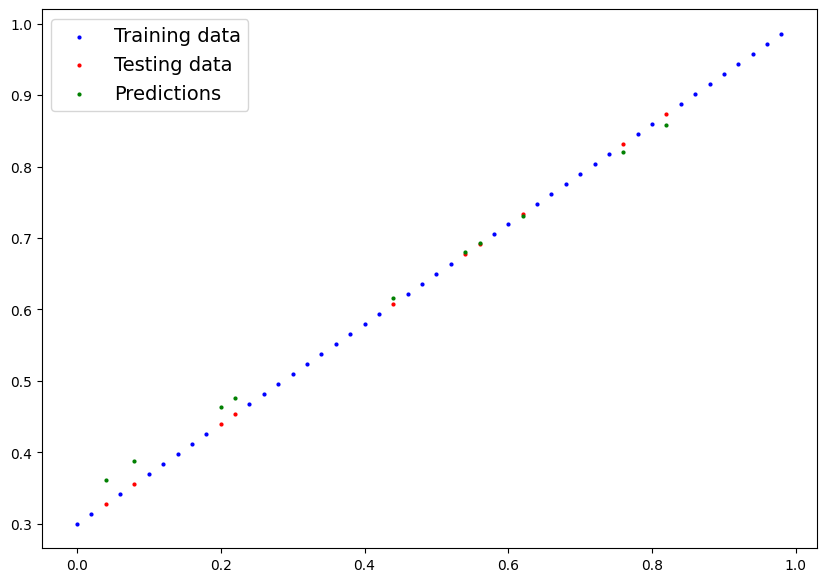

In [18]:
plot_predictions(predictions=y_preds)

Woohoo! Those green dots are looking far closer than they were before!

Let's get onto saving an reloading a model in PyTorch.

5. Saving and loading a PyTorch model

If you've trained a PyTorch model, chances are you'll want to save it and export it somewhere.

As in, you might train it on Google Colab or your local machine with a GPU but you'd like to now export it to some sort of application where others can use it.

Or maybe you'd like to save your progress on a model and come back and load it back later.

> Note: As stated in Python's pickle documentation, the pickle module is not secure. That means you should only ever unpickle (load) data you trust. That goes for loading PyTorch models as well. Only ever use saved PyTorch models from sources you trust.

Saving a PyTorch model's state_dict()

The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

Let's see how we can do that in a few steps:

- We'll create a directory for saving models to called models using Python's `pathlib` module.
- We'll create a file path to save the model to.
- We'll call `torch.save(obj, f)` where obj is the target model's `state_dict()` and `f` is the filename of where to save the model.

> Note: It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`, like `saved_model_01.pth`.

In [19]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME  = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\01_pytorch_workflow_model_0.pth


Loading a saved PyTorch model's `state_dict()`

Since we've now got a saved model `state_dict()` at `models/01_pytorch_workflow_model_0.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where f is the filepath of our saved model `state_dict()`.

Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`?

Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the entire model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of nn.Module).

Why not save the entire model?

Saving the entire model rather than just the `state_dict()` is more intuitive, however, to quote the PyTorch documentation (italics mine):

>The disadvantage of this approach (saving the whole model) is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...

Because of this, your code can break in various ways when used in other projects or after refactors.

So instead, we're using the flexible method of saving and loading just the `state_dict()`, which again is basically a dictionary of model parameters.

Let's test it out by created another instance of LinearRegressionModel(), which is a subclass of torch.nn.Module and will hence have the in-built method `load_state_dict()`.

In [20]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

Excellent! It looks like things matched up.

Now to test our loaded model, let's perform inference with it (make predictions) on the test data.

Remember the rules for performing inference with PyTorch models?

If not, here's a refresher:

1. Set the model in evaluation mode (model.eval()).
2. Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

In [21]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

Now we've made some predictions with the loaded model, let's see if they're the same as the previous predictions.

In [22]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

Nice!

It looks like the loaded model predictions are the same as the previous model predictions (predictions made prior to saving). This indicates our model is saving and loading as expected.

6. Putting it all together

We've covered a fair bit of ground so far.

But once you've had some practice, you'll be performing the above steps like dancing down the street.

Speaking of practice, let's put everything we've done so far together.

Except this time we'll make our code device agnostic (so if there's a GPU available, it'll use it and if not, it will default to the CPU).

There'll be far less commentary in this section than above since what we're going to go through has already been covered.

We'll start by importing the standard libraries we need.

In [23]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu117'

Now let's start making our code device agnostic by setting `device="cuda"` if it's available, otherwise it'll default to `device="cpu"`.

In [24]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


If you've got access to a GPU, the above should've printed out:

> `Using device: cuda`

Otherwise, you'll be using a CPU for the following computations. This is fine for our small dataset but it will take longer for larger datasets.

6.1 Data

Let's create some data just like before.

First, we'll hard-code some weight and bias values.

Then we'll make a range of numbers between 0 and 1, these will be our X values.

Finally, we'll use the X values, as well as the weight and bias values to create y using the linear regression formula (y = weight * X + bias).

In [25]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Wonderful!

Now we've got some data, let's split it into training and test sets.

We'll use an 80/20 split with 80% training data and 20% testing data.

In [26]:
from sklearn.model_selection import train_test_split

# For now we just divide our data into train and test sets

X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Excellent, let's visualize them to make sure they look okay.

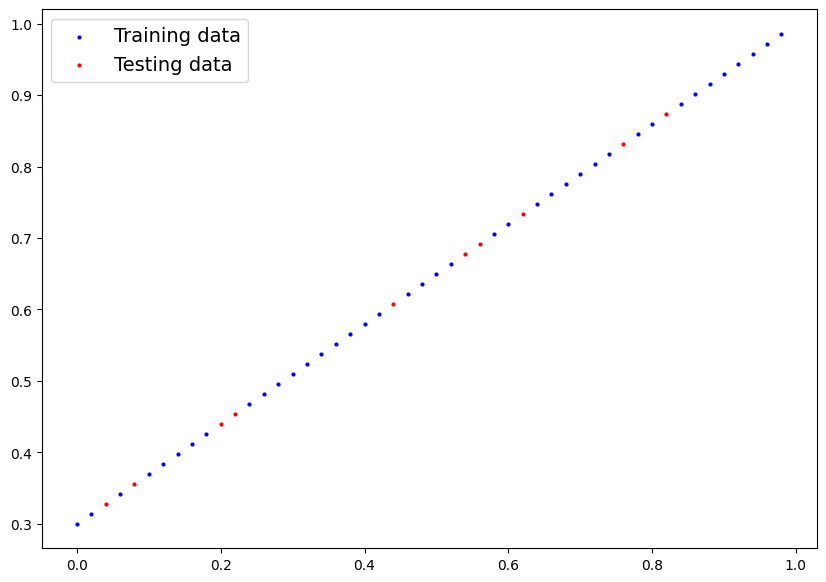

In [27]:
# Note: If you've reset your runtime, this function won't work, 
# you'll have to rerun the cell above where it's instantiated.
plot_predictions(X_train, y_train, X_test, y_test)

6.2 Building a PyTorch linear model

We've got some data, now it's time to make a model.

We'll create the same style of model as before except this time, instead of defining the weight and bias parameters of our model manually using `nn.Parameter()`, we'll use `nn.Linear(in_features, out_features)` to do it for us.

Where `in_features` is the number of dimensions your input data has and `out_features` is the number of dimensions you'd like it to be output to.

In our case, both of these are 1 since our data has 1 input feature (X) per label (y).

![linear-regression-model-w-linear-layer](./images/linear-regression-model-w-linear-layer.png)

*Creating a linear regression model using nn.Parameter versus using nn.Linear. There are plenty more examples of where the torch.nn module has pre-built computations, including many popular and useful neural network layers.*

In [28]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always needed but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

Notice the outputs of `model_1.state_dict()`, the `nn.Linear()` layer created a random weight and bias parameter for us.

Now let's put our model on the GPU (if it's available).

We can change the device our PyTorch objects are on using `.to(device)`.

First let's check the model's current device.

In [29]:
# model_1.parameters() is a generator object
# we need to pass it to next() to get the next item in the generator, and then get where it is stored by using .device
model_1.parameters()

<generator object Module.parameters at 0x0000018FEFCA52E0>

In [30]:
print(list(model_1.parameters()))


# Check model device
next(model_1.parameters()).device

[Parameter containing:
tensor([[0.7645]], requires_grad=True), Parameter containing:
tensor([0.8300], requires_grad=True)]


device(type='cpu')

Wonderful, looks like the model's on the CPU by default.

Let's change it to be on the GPU (if it's available).

In [31]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

6.3 Training

Time to build a training and testing loop.

First we'll need a loss function and an optimizer.

Let's use the same functions we used earlier, `nn.L1Loss()` and `torch.optim.SGD()`.

We'll have to pass the new model's parameters (`model.parameters()`) to the optimizer for it to adjust them during training.

The learning rate of `0.01` worked well before too so let's use that again.

In [32]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

Beautiful, loss function and optimizer ready, now let's train and evaluate our model using a training and testing loop.

The only different thing we'll be doing in this step compared to the previous training loop is putting the data on the target device.

We've already put our model on the target device using model_1.to(device).

And we can do the same with the data.

That way if the model is on the GPU, the data is on the GPU (and vice versa).

Let's step things up a notch this time and set `epochs=1000`.

In [33]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 1000 

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5626322031021118 | Test loss: 0.5454668402671814
Epoch: 100 | Train loss: 0.011667944490909576 | Test loss: 0.010316592641174793
Epoch: 200 | Train loss: 0.00954519398510456 | Test loss: 0.002930581569671631
Epoch: 300 | Train loss: 0.00954519398510456 | Test loss: 0.002930581569671631
Epoch: 400 | Train loss: 0.00954519398510456 | Test loss: 0.002930581569671631
Epoch: 500 | Train loss: 0.00954519398510456 | Test loss: 0.002930581569671631
Epoch: 600 | Train loss: 0.00954519398510456 | Test loss: 0.002930581569671631
Epoch: 700 | Train loss: 0.00954519398510456 | Test loss: 0.002930581569671631
Epoch: 800 | Train loss: 0.00954519398510456 | Test loss: 0.002930581569671631
Epoch: 900 | Train loss: 0.00954519398510456 | Test loss: 0.002930581569671631


> Note: Due to the random nature of machine learning, you will likely get slightly different results (different loss and prediction values) depending on whether your model was trained on CPU or GPU. This is true even if you use the same random seed on either device. If the difference is large, you may want to look for errors, however, if it is small (ideally it is), you can ignore it.

Nice! That loss looks pretty low.

Let's check the parameters our model has learned and compare them to the original parameters we hard-coded.

In [34]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.7040]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3075], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


Ho ho! Now that's pretty darn close to a perfect model.

Remember though, in practice, it's rare that you'll know the perfect parameters ahead of time.

And if you knew the parameters your model had to learn ahead of time, what would be the fun of machine learning?

Plus, in many real-world machine learning problems, the number of parameters can well exceed tens of millions.

I don't know about you but I'd rather write code for a computer to figure those out rather than doing it by hand.

6.4 Making predictions

Now we've got a trained model, let's turn on it's evaluation mode and make some predictions.

In [35]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.7018],
        [0.4624],
        [0.4483],
        [0.8848],
        [0.3357],
        [0.6877],
        [0.8426],
        [0.7440],
        [0.6173],
        [0.3638]], device='cuda:0')

If you're making predictions with data on the GPU, you might notice the output of the above has device='cuda:0' towards the end. That means the data is on CUDA device 0 (the first GPU your system has access to due to zero-indexing), if you end up using multiple GPUs in the future, this number may be higher.

Now let's plot our model's predictions.

> Note: Many data science libraries such as pandas, matplotlib and NumPy aren't capable of using data that is stored on GPU. So you might run into some issues when trying to use a function from one of these libraries with tensor data not stored on the CPU. To fix this, you can call .cpu() on your target tensor to return a copy of your target tensor on the CPU.

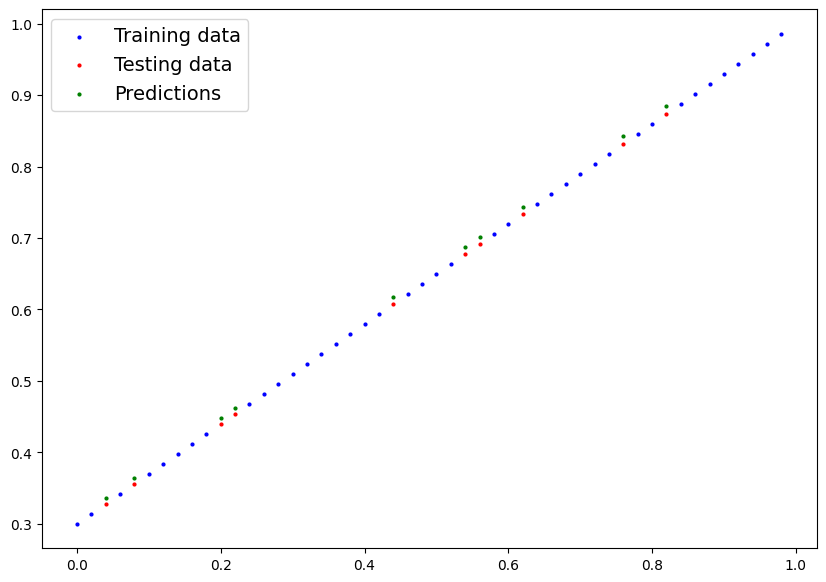

In [36]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

Woah! Look at those green dots, they line up almost perfectly with the red dots. I guess the extra epochs helped.

6.5 Saving and loading a model

We're happy with our models predictions, so let's save it to file so it can be used later.

In [37]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\01_pytorch_workflow_model_1.pth


And just to make sure everything worked well, let's load it back in.

We'll:

- Create a new instance of the `LinearRegressionModelV2()` class
- Load in the model state dict using `torch.nn.Module.load_state_dict()`
- Send the new instance of the model to the target device (to ensure our code is device-agnostic)

In [38]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


Now we can evaluate the loaded model to see if its predictions line up with the predictions made prior to saving.

In [39]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

Everything adds up! Nice!

Well, we've come a long way. You've now built and trained your first two neural network models in PyTorch!

Time to practice your skills.

#### **Exercises**

In [40]:
# Import necessary libraries

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu117'

In [49]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


1. Create a straight line dataset using the linear regression formula (weight * X + bias).

- Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
- Split the data into 80% training, 20% testing.
- Plot the training and testing data so it becomes visual.

In [45]:
# Create weight and bias
weight = 0.3
bias = 0.9

# Create range values, 100 data points
start = 0
end = 2
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.9000],
         [0.9060],
         [0.9120],
         [0.9180],
         [0.9240],
         [0.9300],
         [0.9360],
         [0.9420],
         [0.9480],
         [0.9540]]))

In [46]:
print(X.shape)

torch.Size([100, 1])


In [47]:
from sklearn.model_selection import train_test_split

# For now we just divide our data into train and test sets

X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

len(X_train), len(X_test), len(y_train), len(y_test)

(80, 20, 80, 20)

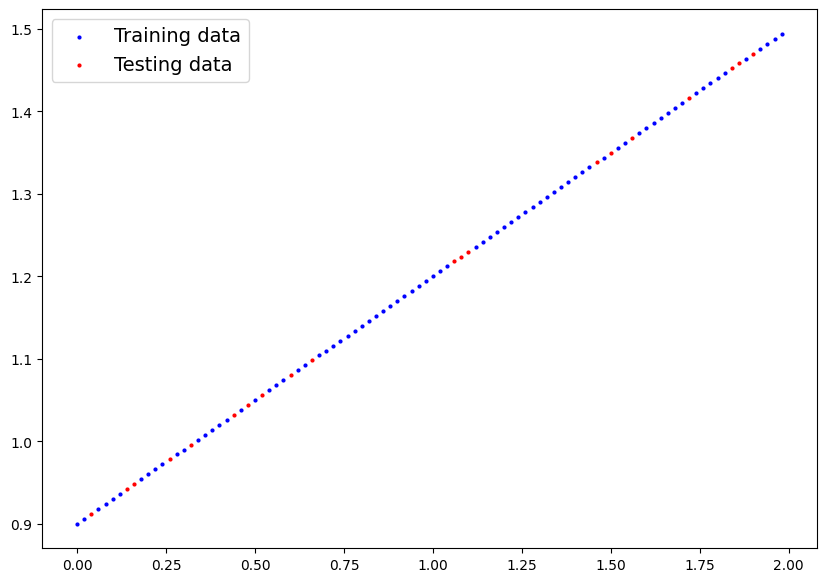

In [48]:
# Note: If you've reset your runtime, this function won't work, 
# you'll have to rerun the cell above where it's instantiated.
plot_predictions(X_train, y_train, X_test, y_test)

2. Build a PyTorch model by subclassing nn.Module.

- Inside should be a randomly initialized nn.Parameter() with requires_grad=True, one for weights and one for bias.
- Implement the `forward()` method to compute the linear regression function you used to create the dataset in 1.
- Once you've constructed the model, make an instance of it and check its `state_dict()`.

> Note: If you'd like to use `nn.Linear()` instead of `nn.Parameter()` you can.

In [50]:
class LinearRegressionModelEx(nn.Module):

    def __init__(self):
        super().__init__()

        self.linear_layer_1 = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.linear_layer_1(x)

        return x

In [54]:
torch.manual_seed(42)
from pprint import pprint

model_x = LinearRegressionModelEx()
pprint(list(model_x.parameters()))
pprint(model_x.state_dict())

[Parameter containing:
tensor([[0.7645]], requires_grad=True),
 Parameter containing:
tensor([0.8300], requires_grad=True)]
OrderedDict([('linear_layer_1.weight', tensor([[0.7645]])),
             ('linear_layer_1.bias', tensor([0.8300]))])


In [60]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_x.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_x.parameters()).device

device(type='cuda', index=0)

3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.

- Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
- Write a training loop to perform the appropriate training steps for 300 epochs.
- The training loop should test the model on the test dataset every 20 epochs.

In [58]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_x.parameters(), # optimize newly created model's parameters
                            lr=0.01)

In [65]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 300

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_x.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_x(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    if (epoch+1)%20 == 0: # testing the model on the test set every 20 epochs
        model_x.eval() # put the model in evaluation mode for testing (inference)
        # 1. Forward pass
        with torch.inference_mode():
            test_pred = model_x(X_test)
        
            # 2. Calculate the loss
            test_loss = loss_fn(test_pred, y_test)
            print(f"Epoch {epoch+1}: {loss} | Epoch {epoch+1}: {test_loss} ")

Epoch 20: 0.010658534243702888 | Epoch 20: 0.009250554256141186 
Epoch 40: 0.010658534243702888 | Epoch 40: 0.009250554256141186 
Epoch 60: 0.010658534243702888 | Epoch 60: 0.009250554256141186 
Epoch 80: 0.010658534243702888 | Epoch 80: 0.009250554256141186 
Epoch 100: 0.010658534243702888 | Epoch 100: 0.009250554256141186 
Epoch 120: 0.010658534243702888 | Epoch 120: 0.009250554256141186 
Epoch 140: 0.010658534243702888 | Epoch 140: 0.009250554256141186 
Epoch 160: 0.010658534243702888 | Epoch 160: 0.009250554256141186 
Epoch 180: 0.010658534243702888 | Epoch 180: 0.009250554256141186 
Epoch 200: 0.010658534243702888 | Epoch 200: 0.009250554256141186 
Epoch 220: 0.010658534243702888 | Epoch 220: 0.009250554256141186 
Epoch 240: 0.010658534243702888 | Epoch 240: 0.009250554256141186 
Epoch 260: 0.010658534243702888 | Epoch 260: 0.009250554256141186 
Epoch 280: 0.010658534243702888 | Epoch 280: 0.009250554256141186 
Epoch 300: 0.010658534243702888 | Epoch 300: 0.009250554256141186 


In [66]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_x.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer_1.weight', tensor([[0.2976]], device='cuda:0')),
             ('linear_layer_1.bias', tensor([0.8930], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.3, bias: 0.9


4. Make predictions with the trained model on the test data.

- Visualize these predictions against the original training and testing data (note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

In [67]:
# Turn model into evaluation mode
model_x.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_x(X_test)
y_preds

tensor([[1.0478],
        [1.4049],
        [0.9049],
        [1.2204],
        [1.3394],
        [1.4465],
        [0.9882],
        [1.3275],
        [1.2144],
        [1.4584],
        [1.2084],
        [1.4406],
        [1.3572],
        [0.9704],
        [0.9347],
        [1.0716],
        [1.0239],
        [1.0358],
        [1.0894],
        [0.9406]], device='cuda:0')

In [69]:
y_preds.shape

torch.Size([20, 1])

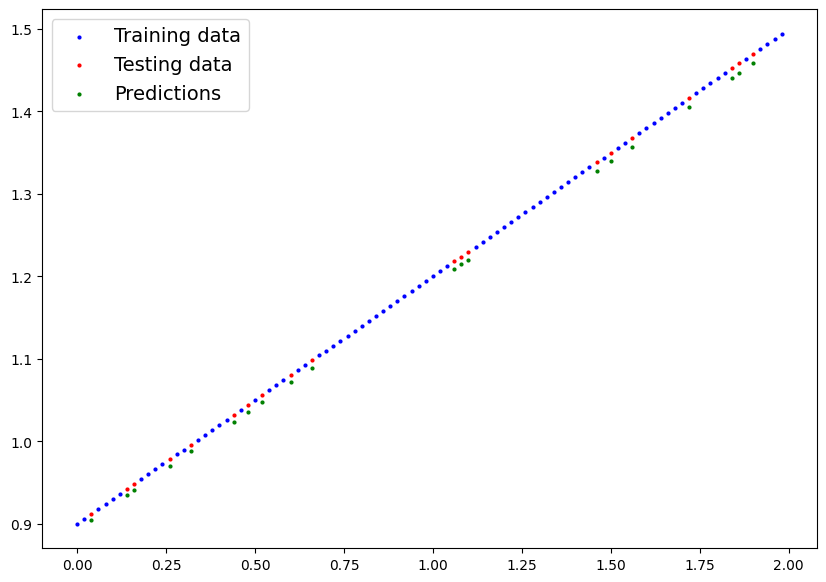

In [71]:
# Put data on the CPU and plot it
plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), predictions=y_preds.cpu())

5. Save your trained model's state_dict() to file.

- Create a new instance of your model class you made in 2. and load in the state_dict() you just saved to it.
- Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [74]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_x.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_x.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_x.pth


In [75]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_x = LinearRegressionModelEx()

# Load model state dict 
loaded_model_x.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_x.to(device)

print(f"Loaded model:\n{loaded_model_x}")
print(f"Model on device:\n{next(loaded_model_x.parameters()).device}")

Loaded model:
LinearRegressionModelEx(
  (linear_layer_1): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [76]:
# Evaluate loaded model
loaded_model_x.eval()

with torch.inference_mode():
    loaded_model_x_preds = loaded_model_x(X_test)
y_preds == loaded_model_x_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

#### **End. Thank you!**